In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


Загрузка данных, добавление столбца приращения

В качестве данных был выбран курс доллара к евро с интервалом 4 часа.
Open -- курс (сколько долларов стоит 1 евро) на момент начала рассматриваемого часа. Будем работать с этими значениями.
delta -- разница в цене рассматриваемого часа с предыдущим. Из выборки было взято 10000 значений, идущих подряд.

In [2]:
currency_data: pd.DataFrame = pd.read_csv("EURUSD_H4.csv", sep="\t", usecols=["Time", "Open"])
currency_data["delta"] = currency_data["Open"].shift(1) - currency_data["Open"]
currency_data = currency_data.fillna(value=0)

currency_data = currency_data.iloc[2500:12500]
print(currency_data.shape)

(10000, 3)


Гистограмма для распределения delta. Столбец -- число записей, попавших в интервал, число интервалов -- 100. 
Строится автоматически, здесь не было задания строить гистограмму вручную

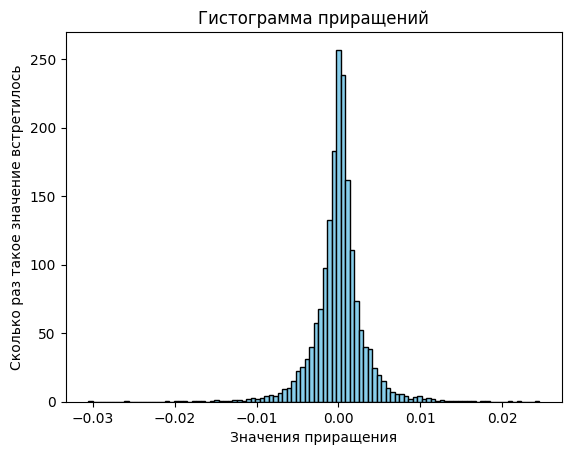

In [3]:

 
# Plotting a basic histogram
plt.hist(currency_data["delta"], bins=100, color='skyblue', edgecolor='black', density=True)
# density -- нормировка, чтобы сумма площадей столбцов была равна 1
 
# Adding labels and title
plt.xlabel('Значения приращения')
plt.ylabel('Сколько раз такое значение встретилось')
plt.title('Гистограмма приращений')
 
# Display the plot
plt.show()

Визуально больше всего похоже на распределение Лапласа. Но проверим позднее

Ядерная оценка плотности.

Формула:
$$f_n(x) = \frac{1}{nh_n} \sum_{i=1}^{i=n}g(\frac{x-x_i}{h_n})$$

$$n -число \ интервалов$$
$$f_n(x) -оценка \ плотности$$
$$h_n -интервал, \ все \ интервалы \ берутся \ одинаковые \ и \ можно \ использовать \ просто \ h$$
$$g - плотность \ известной \ функции, g(x) = G^'(x), G(x) - ядро$$

В курсе упоминалось, что в качестве G часто берут стандартную нормальную функцию распределения. Начнем с нее же.

Тогда 

$$g(x) = \frac{1}{\sqrt{2\pi}}e^{-\frac{1}{2}x^2}$$

Теперь посчитаем. Интервалы берем одинаковые, за левую и правую грани -- минимальные и максимальные значения delta, размер интервала задаем числом n.

Вычисляем минимум, максимум и размер интервала по заданному n

In [4]:
segments_count: int = 200
delta_min: float = np.min(currency_data["delta"])
delta_max: float = np.max(currency_data["delta"])

intervals: np.ndarray = np.linspace(delta_min, delta_max, segments_count)
segment_size: float = (delta_max - delta_min) / segments_count

Функция вычисления плотности стандартного нормального распределения

In [5]:
def std_norm_density(x: float) -> float:
    """Функция плотности стандартного нормального распределения"""
    return (1 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * (x ** 2))

Вычисление плотности по формуле выше

In [6]:
kde_values: np.ndarray = np.zeros_like(intervals)
for x in currency_data["delta"]:
    kde_values += std_norm_density((intervals - x) / segment_size)

kde_values /= (segment_size * len(currency_data))


График полученной плотности и график delta

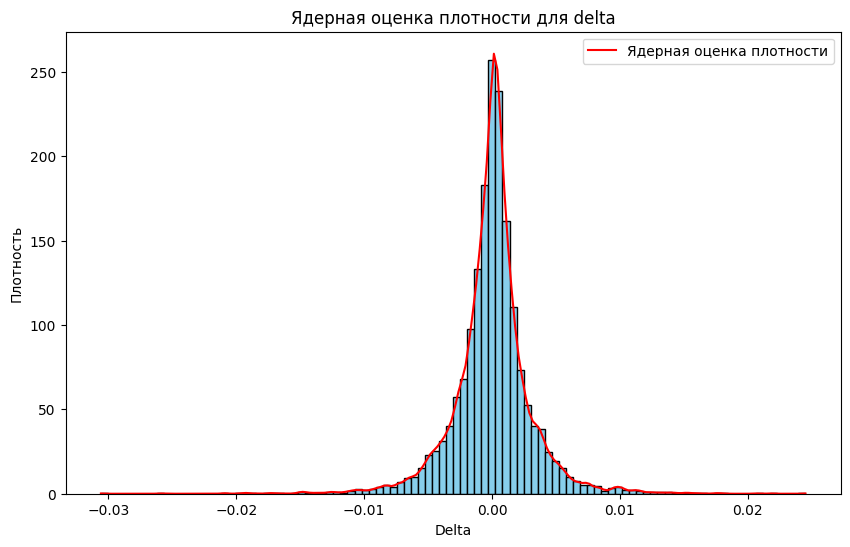

In [7]:
# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(intervals, kde_values, color="red", label='Ядерная оценка плотности')
plt.hist(currency_data["delta"], bins=100, color='skyblue', edgecolor='black', density=True)
plt.xlabel('Delta')
plt.ylabel('Плотность')
plt.title('Ядерная оценка плотности для delta')
plt.legend()
plt.show()

Чем меньше интервалов, тем плавнее график. Чем их больше, тем больше он похож на гистограмму со слишком большим числом сегментов (что логично, в общем-то)